<a href="https://colab.research.google.com/github/Suchetaaa/Vulnerable-Learning/blob/master/finalnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import csv

N, T, t_l, t_e, t_changeKt, kspread = None, None, None, None, None, None # Set later depending on country
samplesPerDay = 10

startingTested = 14
daysOffset = 14

In [0]:
from google.colab import files
uploaded = files.upload()

Saving maharashtra_time_series.csv to maharashtra_time_series.csv


In [0]:
## THE SIER-X MODEL
def getPreds(beta = 0.2, beta1 = 0.1, sigma = 1/38.0, plot = False):
    global N, T, t_l, t_e, t_changeKt, kspread
    # Total population, N.

    # Initial number of infected and recovered individuals, I0 and R0.
    # Everyone else, S0, is susceptible to infection initially.

    K0 = 1./7
    MU = 1./7
    gamma1 = 1./19
    gamma2 = 1./14
    gamma3 = 1./14
    b1 = beta1
    b2 = 0.1 * beta1
    b3 = 0.002 * beta1
    
#     A0, I0, Xs0, Xa0, Xi0, P0, R0 = 1, 0, 0, 0, 0, 0, 0
    totalInfected = startingTested * 20; pIgivenA = 0.33
    A0 = totalInfected * (1.0 - pIgivenA) ;P0 = startingTested;I0 = totalInfected * pIgivenA - P0 ;Xs0 = 0;Xa0 = 0;Xi0 = 0; R0 = 0
    
    S0 = N - A0 - I0 - Xs0 - Xa0 - Xi0 - P0 - R0

    t = np.linspace(0, T, samplesPerDay*T)

    def deriv(y, t, N, beta):
        S, A, I, Xs, Xa, Xi, P, R = y

        if t < t_l or t > t_e:
            k0 = 0
        else:
            k0 = K0
            
        if t > t_changeKt:
            kt = kt2 = 0.5
        else:
            kt = 0.075; kt2 = 0

        if t > t_e:
            mu = MU
        else:
            mu = 0

        dSdt = - beta * (I + kspread * (A + b1 * Xa) + b2 * Xi + b3 * P) * S/N - k0 * S + mu * Xs
        dAdt = beta * (I + kspread * (A + b1 * Xa) + b2 * Xi + b3 * P) * S/N - sigma * A - k0 * A + mu * Xa - gamma1 * A - kt2 * A
        dIdt = sigma * A  - kt * I - k0 * I + mu * Xi - gamma2 * I

        dXsdt = - beta * beta1 * (I + kspread * (A + b1 * Xa) + b2 * Xi + b3 * P) * Xs/N + k0 * S - mu * Xs
        dXadt = beta * beta1 * (I + kspread * (A + b1 * Xa) + b2 * Xi + b3 * P) * Xs/N - sigma * Xa + k0 * A - mu * Xa - gamma1 * Xa - kt2 * Xa
        dXidt = sigma * Xa - kt * Xi + k0 * I - mu * Xi - gamma2 * Xi

        dPdt = kt * (I + Xi) - gamma3 * P + kt2 * (A + Xa)
        dRdt = gamma1 * (A + Xa) + gamma2 * (I + Xi) + gamma3 * P

        return dSdt, dAdt, dIdt, dXsdt, dXadt, dXidt, dPdt, dRdt

    # Initial conditions vector
    y0 = S0, A0, I0, Xs0, Xa0, Xi0, P0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta))
    S, A, I, Xs, Xa, Xi, P, R = ret.T
    if not plot: return P, R
    else: return P, I + Xi + P, P + I + Xi + A + Xa

# temp = getPreds(0.31, 0)

In [0]:
## READ DATA
def readDataIndia(startDate = None):
    # Start reading data from the startDate and subtract the number of confirmed, recovered and dead 
    # at the startDate from all future points
    file = open('india_time_series.csv', 'r')
    reader = csv.reader(file)
    confirmedOffset, recoveredOffset, deadOffset = 0, 0, 0
    confirmed, recovered, dead = None, None, None
    i, r = [], []
    for row in reader:
        if startDate is not None and (startDate.strip() == row[0].strip()):
            startDate = None
            confirmedOffset = int(row[2])
            recoveredOffset = int(row[4])
            deadOffset = int(row[6])
        if startDate is None:
            confirmed = int(row[2]) - confirmedOffset
            recovered = int(row[4]) - recoveredOffset
            dead = int(row[6]) - deadOffset
            r.append(recovered + dead)
            i.append(confirmed - r[-1])
    file.close()
    return i, r

def readDataMaharashtra(startIndex = 0):
    file = open('maharashtra_time_series.csv', 'r')
    reader = csv.reader(file)
    confirmed, recovered, dead = None, None, None
    count = -1
    i, r = [], []
    for row in reader:
        count += 1
        if count < startIndex: continue
        confirmed = int(row[2])
        recovered = int(row[4])
        dead = int(row[6])
        r.append(recovered + dead)
        i.append(confirmed - r[-1])
    file.close()
    return i, r

# Start from March 01, when the first case in this spread started, adjust counts as needed
# actualI, actualR = readDataIndia(startDate = "01 March")
# T = 50
# t_l = 23 # From 24 March, ignore Janta Curfew?
# t_e = 44
# actualI = np.asarray(actualI); actualR = np.asarray(actualR)
# N = 1300000000

# actualI, actualR = readDataIndia(startDate = "01 March")
# T = 50 - daysOffset
# t_l = 23 - daysOffset# From 24 March, ignore Janta Curfew?
# t_e = 44 - daysOffset
# actualI = np.asarray(actualI[daysOffset:]); actualR = np.asarray(actualR[daysOffset:])
# N = 1300000000


# Maharashtra Data
actualI, actualR = readDataMaharashtra()
actualI = np.asarray(actualI); actualR = np.asarray(actualR)
T = 50 - daysOffset
t_l = 24 - daysOffset
t_e = 24 + 21 - daysOffset
N = 110000000
t_changeKt = 1000000000
kspread = 1.0

In [0]:
# Define loss and search for the best hyperparameters (grid search for now)
def squaredLoss(preds, target):
    loss = ((preds - target) ** 2).sum()
    return loss

eps = 1e-8
def squaredLossExpScale(preds, target):
    preds = np.log(preds + eps)
    target = np.log(target + eps)
    loss = ((preds - target) ** 2).sum()
    return loss

bestLoss = 10000000000
bestBeta, bestBeta1 = -1, -1
bestPreds = None
betaValues = np.linspace(0.1, 0.6, 51)
beta1Values = np.linspace(0.6, 1.0, 41)
losses = np.zeros((len(betaValues), len(beta1Values)))

for i, beta in enumerate(betaValues):
    for j, beta1 in enumerate(beta1Values):
        predI, predR = getPreds(beta = beta, beta1 = beta1)
        trimmedPredI = predI[:len(actualI) * samplesPerDay:samplesPerDay]
        trimmedPredR = predR[:len(actualR) * samplesPerDay:samplesPerDay]
        assert len(trimmedPredI) == len(actualI) and len(trimmedPredR) == len(actualR), "Length mismatch"
        loss = squaredLoss(trimmedPredI, actualI)
        losses[i, j] = loss
        
        if loss < bestLoss:
            bestLoss = loss
            bestPreds = predI, predR
            bestBeta = beta; bestBeta1 = beta1

print("Best beta value", bestBeta)
print("Best beta1 value", bestBeta1)
print("Best loss value", bestLoss)

Best beta value 0.31
Best beta1 value 0.71
Best loss value 11984.354933934002


Total population of Maharashtra: 114200000
Maximum people tested positive at the same time: 74978
Maximum people symptomatic at the same time: 75985
Maximum people infected at the same time: 90844


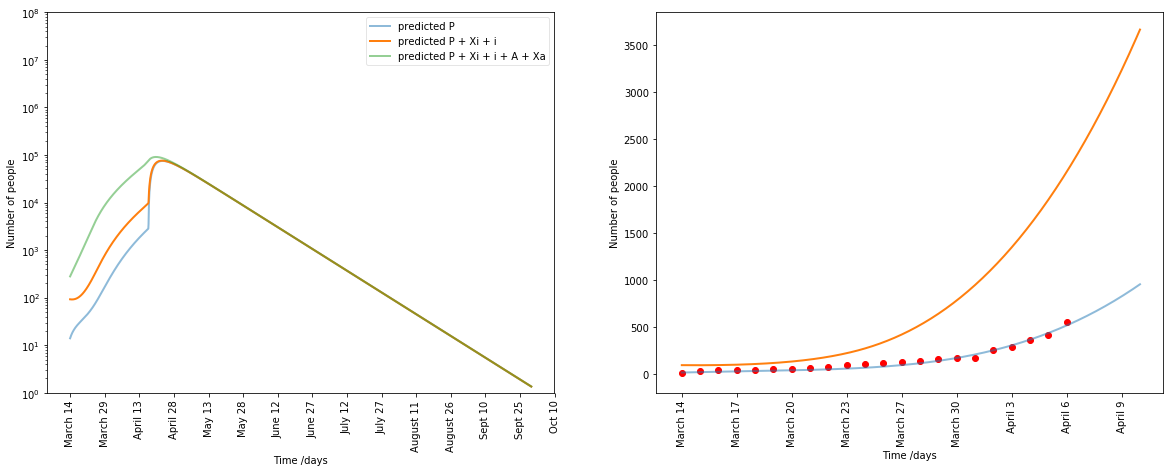

In [0]:
beta = 0.31; beta1 = 0.71
T = 200; T2 = 25
kspread = 1.0

t_e = 24 + 21 - daysOffset
t_changeKt = 10000000000#48 - daysOffset
pLock, totalLock, total2Lock = getPreds(beta, beta1, plot = True)

print("Total population of Maharashtra: 114200000")
print("Maximum people tested positive at the same time: " + str(int(pLock.max() + 0.5)))
print("Maximum people symptomatic at the same time: " + str(int(totalLock.max() + 0.5)))
print("Maximum people infected at the same time: " + str(int(total2Lock.max() + 0.5)))

fig, (ax, ax2) = plt.subplots(1, 2, facecolor='w', figsize=(20, 7))
t = np.linspace(0, T, samplesPerDay * T + 1)
ax.plot(t[:len(pLock)], pLock, alpha=0.5, lw=2, label='predicted P')
ax.plot(t[:len(totalLock)], totalLock, lw=2, label='predicted P + Xi + i')
ax.plot(t[:len(total2Lock)], total2Lock, alpha=0.5, lw=2, label='predicted P + Xi + i + A + Xa')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number of people')
ax.set_yscale('log')
ax.set_ylim(1, 1e8)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
ax.set_xticklabels(['', 'March 14', 'March 29', 'April 13', 'April 28', 'May 13', 'May 28', 'June 12', 'June 27',\
                   'July 12', 'July 27', 'August 11', 'August 26', 'Sept 10', 'Sept 25', 'Oct 10', 'Oct 25',\
                   'Nov 9', 'Nov 24', 'Dec 9', 'Dec 24', 'Jan 8'], rotation = 'vertical')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

t = np.linspace(0, T2, samplesPerDay * T2 + 1)
ax2.plot(t, pLock[:len(t)], alpha=0.5, lw=2, label='predicted P')
ax2.plot(t, totalLock[:len(t)], lw=2, label='predicted P + Xi + i')
# ax2.plot(t, total2Lock[:len(t)], alpha=0.5, lw=2, label='predicted P + Xi + i + A + Xa')
ax2.scatter(list(range(len(actualI))), actualI, c = 'r', label='actual P')
ax2.set_xlabel('Time /days')
ax2.set_ylabel('Number of people')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax2.set_xticklabels(['', 'March 14', 'March 17', 'March 20', 'March 23', 'March 27', 'March 30', 'April 3', \
                    'April 6', 'April 9', 'April 12', 'April 15', 'April 18', 'April 21', 'April 24'], rotation = 'vertical')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

plt.show()

Total population of Maharashtra: 114200000
Maximum people tested positive at the same time: 140712
Maximum people symptomatic at the same time: 142516
Maximum people infected at the same time: 170335


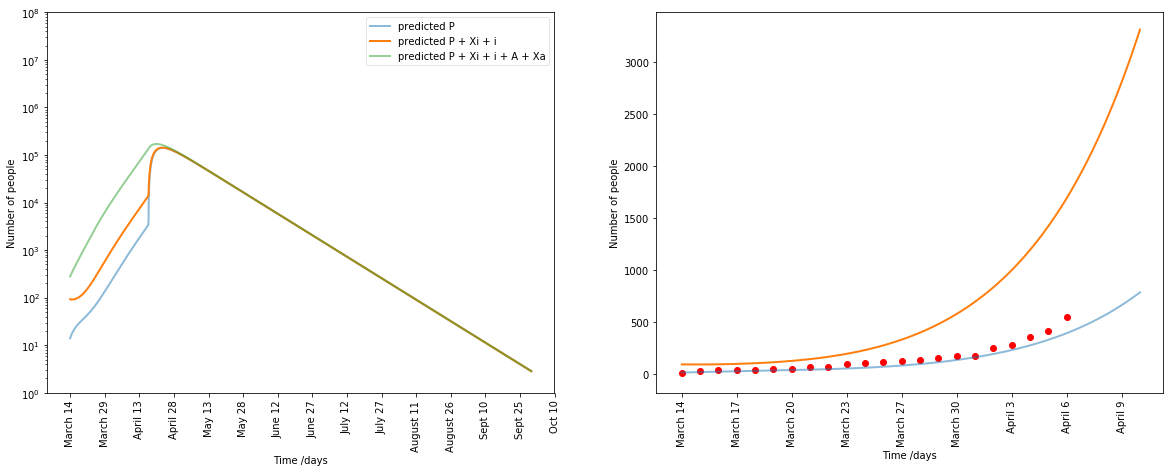

In [0]:
beta = 0.5; beta1 = 0.95
T = 200; T2 = 25
kspread = 0.5

t_e = 24 + 21 - daysOffset
t_changeKt = 10000000000#48 - daysOffset
pLock, totalLock, total2Lock = getPreds(beta, beta1, plot = True)

print("Total population of Maharashtra: 114200000")
print("Maximum people tested positive at the same time: " + str(int(pLock.max() + 0.5)))
print("Maximum people symptomatic at the same time: " + str(int(totalLock.max() + 0.5)))
print("Maximum people infected at the same time: " + str(int(total2Lock.max() + 0.5)))

fig, (ax, ax2) = plt.subplots(1, 2, facecolor='w', figsize=(20, 7))
t = np.linspace(0, T, samplesPerDay * T + 1)
ax.plot(t[:len(pLock)], pLock, alpha=0.5, lw=2, label='predicted P')
ax.plot(t[:len(totalLock)], totalLock, lw=2, label='predicted P + Xi + i')
ax.plot(t[:len(total2Lock)], total2Lock, alpha=0.5, lw=2, label='predicted P + Xi + i + A + Xa')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number of people')
ax.set_yscale('log')
ax.set_ylim(1, 1e8)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
ax.set_xticklabels(['', 'March 14', 'March 29', 'April 13', 'April 28', 'May 13', 'May 28', 'June 12', 'June 27',\
                   'July 12', 'July 27', 'August 11', 'August 26', 'Sept 10', 'Sept 25', 'Oct 10', 'Oct 25',\
                   'Nov 9', 'Nov 24', 'Dec 9', 'Dec 24', 'Jan 8'], rotation = 'vertical')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

t = np.linspace(0, T2, samplesPerDay * T2 + 1)
ax2.plot(t, pLock[:len(t)], alpha=0.5, lw=2, label='predicted P')
ax2.plot(t, totalLock[:len(t)], lw=2, label='predicted P + Xi + i')
# ax2.plot(t, total2Lock[:len(t)], alpha=0.5, lw=2, label='predicted P + Xi + i + A + Xa')
ax2.scatter(list(range(len(actualI))), actualI, c = 'r', label='actual P')
ax2.set_xlabel('Time /days')
ax2.set_ylabel('Number of people')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax2.set_xticklabels(['', 'March 14', 'March 17', 'March 20', 'March 23', 'March 27', 'March 30', 'April 3', \
                    'April 6', 'April 9', 'April 12', 'April 15', 'April 18', 'April 21', 'April 24'], rotation = 'vertical')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

plt.show()

NUMBER OF CASES PER DISTRICT

In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
import pandas as pd

df=pd.read_csv('patients.csv')
district_df = df.groupby('detecteddistrict')

district_list=[]
total_cases_list=[]
for name, group in district_df:  
    district_list.append(name)
    total_cases_list.append(len(group.index))

consolidated_df=pd.DataFrame(list(zip(district_list, total_cases_list)), 
               columns =['district_name', 'total_cases']) 
consolidated_df.sort_values(by=['total_cases'], inplace=True, ascending=False)
consolidated_df.to_csv('district_final.csv', header=False, index=False)

In [0]:
from google.colab import files
files.download('district_final.csv') 

TIME_SERIES_DATA OF DISTRICTS

In [0]:
import pandas as pd

def Reverse(lst): 
    return [ele for ele in reversed(lst)] 

df=pd.read_csv('patients.csv')
district_df = df.groupby('detecteddistrict')

mum_df=district_df.get_group('Mumbai')
mum_df_1=mum_df[['currentstatus','dateannounced','detecteddistrict','statuschangedate']]

confirmed_list=[]
deceased_list=[]
recovered_list=[]

confirmed_total=[]
deceased_total=[]
recovered_total=[]

confirmed_t=0
deceased_t=0
recovered_t=0

date_list=mum_df_1.dateannounced.unique()
date_list=Reverse(date_list)

for date in date_list:
  confirmed=0
  deceased=0
  recovered=0
  for index, row in mum_df_1.iterrows(): 
    if(row['dateannounced']==date):
      confirmed+=1
    if(row['statuschangedate']==date and row['currentstatus']=='Recovered'):
      recovered+=1
    if(row['statuschangedate']==date and row['currentstatus']=='Deceased'):
      deceased+=1 
  
  confirmed_t+=confirmed
  deceased_t+=deceased
  recovered_t+=recovered
  
  confirmed_list.append(confirmed)
  confirmed_total.append(confirmed_t)
  deceased_list.append(deceased)
  deceased_total.append(deceased_t)
  recovered_list.append(recovered) 
  recovered_total.append(recovered_t)

consolidated_df=pd.DataFrame(list(zip(date_list, confirmed_list, confirmed_total, recovered_list, recovered_total, deceased_list, deceased_total)), 
               columns =['date', 'confirmed_cases', 'total_confirmed', 'recovered_cases', 'total_recovered', 'deceased_cases', 'total_deceased'])

consolidated_df.to_csv('mumbai.csv', header=False, index=False)

In [0]:
from google.colab import files
files.download('mumbai.csv') 

In [0]:
#All districts
import pandas as pd

def Reverse(lst): 
    return [ele for ele in reversed(lst)] 

df=pd.read_csv('patients.csv')
district_df = df.groupby('detecteddistrict')
district_list=[]
total_cases_list=[]
for name, group in district_df:  
    district_list.append(name)
    total_cases_list.append(len(group.index))

consolidated_df=pd.DataFrame(list(zip(district_list, total_cases_list)), 
               columns =['district_name', 'total_cases']) 
consolidated_df.sort_values(by=['total_cases'], inplace=True, ascending=False)
consolidated_df.to_csv('district_final.csv', header=False, index=False)

for district in district_list:
  mum_df=district_df.get_group(district)
  mum_df_1=mum_df[['currentstatus','dateannounced','detecteddistrict','statuschangedate']]

  confirmed_list=[]
  deceased_list=[]
  recovered_list=[]

  confirmed_total=[]
  deceased_total=[]
  recovered_total=[]

  confirmed_t=0
  deceased_t=0
  recovered_t=0

  date_list=mum_df_1.dateannounced.unique()
  date_list=Reverse(date_list)

  for date in date_list:
    confirmed=0
    deceased=0
    recovered=0
    for index, row in mum_df_1.iterrows(): 
      if(row['dateannounced']==date):
        confirmed+=1
      if(row['statuschangedate']==date and row['currentstatus']=='Recovered'):
        recovered+=1
      if(row['statuschangedate']==date and row['currentstatus']=='Deceased'):
        deceased+=1 
  
    confirmed_t+=confirmed
    deceased_t+=deceased
    recovered_t+=recovered
  
    confirmed_list.append(confirmed)
    confirmed_total.append(confirmed_t)
    deceased_list.append(deceased)
    deceased_total.append(deceased_t)
    recovered_list.append(recovered) 
    recovered_total.append(recovered_t)

  final_df=pd.DataFrame(list(zip(date_list, confirmed_list, confirmed_total, recovered_list, recovered_total, deceased_list, deceased_total)), 
               columns =['date', 'confirmed_cases', 'total_confirmed', 'recovered_cases', 'total_recovered', 'deceased_cases', 'total_deceased'])

  final_df.to_csv(district+'.csv', header=False, index=False)

MODEL TRAINING FOR DISTRICT_WISE BETA

In [0]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import csv

N, T, t_l, t_e, t_changeKt, kspread = None, None, None, None, None, None # Set later depending on country
samplesPerDay = 10

startingTested = 14
daysOffset = 14

In [0]:
## THE SIER-X MODEL
def getPreds(beta = 0.2, beta1 = 0.1, sigma = 1/38.0, plot = False):
    global N, T, t_l, t_e, t_changeKt, kspread
    # Total population, N.

    # Initial number of infected and recovered individuals, I0 and R0.
    # Everyone else, S0, is susceptible to infection initially.

    K0 = 1./7
    MU = 1./7
    gamma1 = 1./19
    gamma2 = 1./14
    gamma3 = 1./14
    b1 = beta1
    b2 = 0.1 * beta1
    b3 = 0.002 * beta1
    
#     A0, I0, Xs0, Xa0, Xi0, P0, R0 = 1, 0, 0, 0, 0, 0, 0
    totalInfected = startingTested * 20; pIgivenA = 0.33
    A0 = totalInfected * (1.0 - pIgivenA) ;P0 = startingTested;I0 = totalInfected * pIgivenA - P0 ;Xs0 = 0;Xa0 = 0;Xi0 = 0; R0 = 0
    
    S0 = N - A0 - I0 - Xs0 - Xa0 - Xi0 - P0 - R0

    t = np.linspace(0, T, samplesPerDay*T)

    def deriv(y, t, N, beta):
        S, A, I, Xs, Xa, Xi, P, R = y

        if t < t_l or t > t_e:
            k0 = 0
        else:
            k0 = K0
            
        if t > t_changeKt:
            kt = kt2 = 0.5
        else:
            kt = 0.075; kt2 = 0

        if t > t_e:
            mu = MU
        else:
            mu = 0

        dSdt = - beta * (I + kspread * (A + b1 * Xa) + b2 * Xi + b3 * P) * S/N - k0 * S + mu * Xs
        dAdt = beta * (I + kspread * (A + b1 * Xa) + b2 * Xi + b3 * P) * S/N - sigma * A - k0 * A + mu * Xa - gamma1 * A - kt2 * A
        dIdt = sigma * A  - kt * I - k0 * I + mu * Xi - gamma2 * I

        dXsdt = - beta * beta1 * (I + kspread * (A + b1 * Xa) + b2 * Xi + b3 * P) * Xs/N + k0 * S - mu * Xs
        dXadt = beta * beta1 * (I + kspread * (A + b1 * Xa) + b2 * Xi + b3 * P) * Xs/N - sigma * Xa + k0 * A - mu * Xa - gamma1 * Xa - kt2 * Xa
        dXidt = sigma * Xa - kt * Xi + k0 * I - mu * Xi - gamma2 * Xi

        dPdt = kt * (I + Xi) - gamma3 * P + kt2 * (A + Xa)
        dRdt = gamma1 * (A + Xa) + gamma2 * (I + Xi) + gamma3 * P

        return dSdt, dAdt, dIdt, dXsdt, dXadt, dXidt, dPdt, dRdt

    # Initial conditions vector
    y0 = S0, A0, I0, Xs0, Xa0, Xi0, P0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta))
    S, A, I, Xs, Xa, Xi, P, R = ret.T
    if not plot: return P, R
    else: return P, I + Xi + P, P + I + Xi + A + Xa

# temp = getPreds(0.31, 0)

In [0]:
def readDataMaharashtra(startIndex = 0):
    file = open('kasaragod_2.csv', 'r')
    reader = csv.reader(file)
    confirmed, recovered, dead = None, None, None
    count = -1
    i, r = [], []
    for row in reader:
        count += 1
        if count < startIndex: continue
        confirmed = int(row[2])
        recovered = int(row[4])
        dead = int(row[6])
        r.append(recovered + dead)
        i.append(confirmed - r[-1])
    file.close()
    return i, r

# Start from March 01, when the first case in this spread started, adjust counts as needed
# actualI, actualR = readDataIndia(startDate = "01 March")
# T = 50
# t_l = 23 # From 24 March, ignore Janta Curfew?
# t_e = 44
# actualI = np.asarray(actualI); actualR = np.asarray(actualR)
# N = 1300000000

# actualI, actualR = readDataIndia(startDate = "01 March")
# T = 50 - daysOffset
# t_l = 23 - daysOffset# From 24 March, ignore Janta Curfew?
# t_e = 44 - daysOffset
# actualI = np.asarray(actualI[daysOffset:]); actualR = np.asarray(actualR[daysOffset:])
# N = 1300000000


# Maharashtra Data
actualI, actualR = readDataMaharashtra()
actualI = np.asarray(actualI); actualR = np.asarray(actualR)
T = 50 - daysOffset
t_l = 24 - daysOffset
t_e = 24 + 21 - daysOffset
N = 110000000
t_changeKt = 1000000000
kspread = 1.0

In [0]:
# Define loss and search for the best hyperparameters (grid search for now)
def squaredLoss(preds, target):
    loss = ((preds - target) ** 2).sum()
    return loss

eps = 1e-8
def squaredLossExpScale(preds, target):
    preds = np.log(preds + eps)
    target = np.log(target + eps)
    loss = ((preds - target) ** 2).sum()
    return loss

bestLoss = 10000000000
bestBeta, bestBeta1 = -1, -1
bestPreds = None
betaValues = np.linspace(0.1, 0.6, 51)
beta1Values = np.linspace(0.6, 1.0, 41)
losses = np.zeros((len(betaValues), len(beta1Values)))

for i, beta in enumerate(betaValues):
    for j, beta1 in enumerate(beta1Values):
        predI, predR = getPreds(beta = beta, beta1 = beta1)
        trimmedPredI = predI[:len(actualI) * samplesPerDay:samplesPerDay]
        trimmedPredR = predR[:len(actualR) * samplesPerDay:samplesPerDay]
        assert len(trimmedPredI) == len(actualI) and len(trimmedPredR) == len(actualR), "Length mismatch"
        loss = squaredLoss(trimmedPredI, actualI)
        losses[i, j] = loss
        
        if loss < bestLoss:
            bestLoss = loss
            bestPreds = predI, predR
            bestBeta = beta; bestBeta1 = beta1

print("Best beta value", bestBeta)
print("Best beta1 value", bestBeta1)
print("Best loss value", bestLoss)

Best beta value 0.23
Best beta1 value 0.6
Best loss value 11225.12653617229
